In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/MyDrive/Project_Machine_Learning')

Mounted at /content/drive/


# **Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
# from pycaret.classification import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# **1 - Loading Dataset**

In [ ]:
df_train = pd.read_csv('https://raw.githubusercontent.com/mdsohaib/BBC-News-Classification/master/bbc-text.csv')
# df_train = pd.read_csv('/content/drive/MyDrive/Project_Machine_Learning/dataset/BBC News Train.csv')

# Assuming df_train is your DataFrame
df_train = df_train.rename(columns={'category': 'Category', 'text': 'Text'})
df_train.head()

df_train.shape
data = df_train

In [ ]:
# df_train = df_train.drop(columns=['ArticleId'])
df_train.columns


Index(['Category', 'Text'], dtype='object')

#**2 - Text Pre-Treatment and Representation**

**Missing Values**

In [ ]:
df_train.info() #no null values are there

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [ ]:
df_train.isna().sum() #no empty string also

Category    0
Text        0
dtype: int64

**duplicate**

In [ ]:
df_train.nunique() # since article id 1490 and unique text is only 1440 then 50 text is duplicate

Category       5
Text        2126
dtype: int64

In [ ]:
df_train['text_multiple'] = df_train.groupby('Text')['Text'].transform('count')
print('Maximum number of duplicated Text:', df_train.text_multiple.max(), '\nDuplicated Text and the Category they appeared in:')
train_duplicates = df_train[df_train.text_multiple == 2]
train_duplicates.groupby('Text')['Category'].apply(lambda x: ', '.join(x)).reset_index()

Maximum number of duplicated Text: 2 
Duplicated Text and the Category they appeared in:


,Text,Category
0,2d metal slug offers retro fun like some drill...,"tech, tech"
1,apple attacked over sources row civil libertie...,"tech, tech"
2,apple ipod family expands market apple has exp...,"tech, tech"
3,apple unveils low-cost mac mini apple has un...,"tech, tech"
4,ask jeeves joins web log market ask jeeves has...,"tech, tech"
...,...,...
94,us peer-to-peer pirates convicted the first co...,"tech, tech"
95,virus poses as christmas e-mail security firms...,"tech, tech"
96,warning over tsunami aid website net users are...,"tech, tech"
97,web radio takes spanish rap global spin the ra...,"tech, tech"


In [ ]:
df_train = df_train.drop_duplicates(subset=['Text'], ignore_index=True) #removing duplicate text

**Visualization**

In [ ]:
class_counts = df_train.Category.value_counts()
class_counts

Category
sport            504
business         503
politics         403
entertainment    369
tech             347
Name: count, dtype: int64

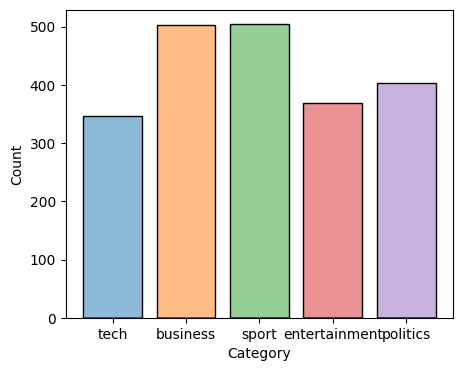

In [ ]:
plt.figure(figsize=(5, 4))
sns.histplot(df_train, x='Category', hue='Category', shrink=.8, legend=False);

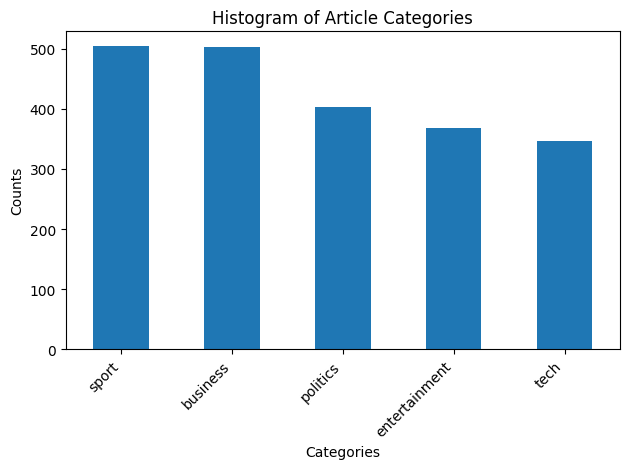

In [ ]:
# plot the category distribution
ax = class_counts.plot(kind='bar')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.title('Histogram of Article Categories')
ax.set_xticklabels(class_counts.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Counting Word and Adding a new Column**

In [ ]:
def calculate_word_count(text):
    return len(text.split())

In [ ]:
df_train['Word_Count'] = df_train['Text'].apply(calculate_word_count) #adding in train
df_train.head()

<ipython-input-16-4e2e61d68c8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Word_Count'] = df_train['Text'].apply(calculate_word_count) #adding in train


,Category,Text,text_multiple,Word_Count
0,tech,tv future in the hands of viewers with home th...,1,737
1,business,worldcom boss left books alone former worldc...,1,300
2,sport,tigers wary of farrell gamble leicester say ...,1,246
3,sport,yeading face newcastle in fa cup premiership s...,1,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,2,260


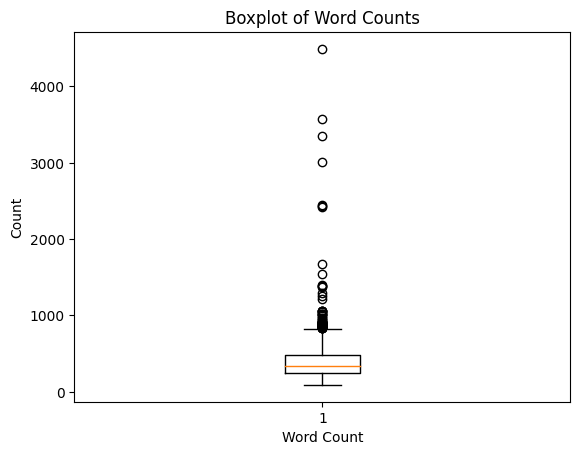

In [ ]:
# Word count boxplot to see if there are outliers exists or not
plt.boxplot(df_train['Word_Count'])
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Boxplot of Word Counts')
plt.show()
# we can see there are most of text column contains upto 500 words and some are consisting too many words kinda outliers

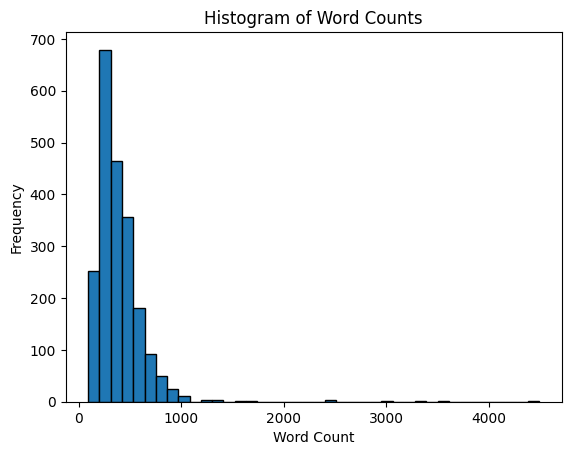

In [ ]:
# To visulaize it in another way
plt.hist(df_train['Word_Count'], bins=40, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
plt.show()

In [ ]:
df_train.tail()

,Category,Text,text_multiple,Word_Count
2121,business,cars pull down us retail figures us retail sal...,1,293
2122,politics,kilroy unveils immigration policy ex-chatshow ...,1,156
2123,entertainment,rem announce new glasgow concert us band rem h...,1,301
2124,politics,how political squabbles snowball it s become c...,1,858
2125,sport,souness delight at euro progress boss graeme s...,1,229


In [ ]:
# as we have seen most of words containing text or lets say articles most of articles containing words under 1000 so we remove the outliers from our dataset
df_train = df_train[df_train['Word_Count'] <= 2000]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2119 entries, 0 to 2125
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category       2119 non-null   object
 1   Text           2119 non-null   object
 2   text_multiple  2119 non-null   int64 
 3   Word_Count     2119 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [ ]:
df_train.head()

,Category,Text,text_multiple,Word_Count
0,tech,tv future in the hands of viewers with home th...,1,737
1,business,worldcom boss left books alone former worldc...,1,300
2,sport,tigers wary of farrell gamble leicester say ...,1,246
3,sport,yeading face newcastle in fa cup premiership s...,1,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,2,260


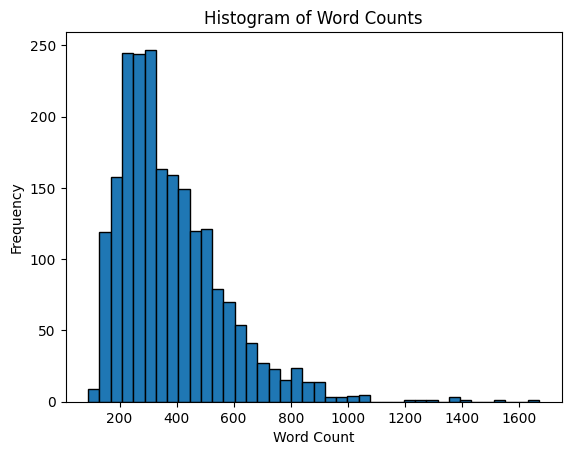

In [ ]:
plt.hist(df_train['Word_Count'], bins=40, edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')

plt.show()

In [ ]:
df_train.head()

,Category,Text,text_multiple,Word_Count
0,tech,tv future in the hands of viewers with home th...,1,737
1,business,worldcom boss left books alone former worldc...,1,300
2,sport,tigers wary of farrell gamble leicester say ...,1,246
3,sport,yeading face newcastle in fa cup premiership s...,1,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,2,260


## **Text Preprocessing**



**before cleaning text**

In [ ]:
df_train['Text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

**To Clean Our Data We Perform Following Steps**


1.   Convert to lowercase
2.   Remove Punctuation
3.   Remove numbers
4.   Remove stop words
5.   Remove words with 2 or less characters
6.   Remove multiple spaces



**getting english stop words**

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'she', 'or', 'too', 'her', 'be', 'no', "you'll", 'an', "shouldn't", 'here', 'on', 'do', 'are', 'doing', 'll', 'off', 'now', 'couldn', 'and', 'have', 'whom', 'shan', 'nor', 'through', "that'll", 'those', 'doesn', 'being', 'not', "didn't", 'by', 'ours', 'that', 'did', 'few', 'am', 'their', 'yourself', 'before', 'again', 'about', 'needn', 've', 'there', 'any', 'between', 'from', 'ain', 'if', 'with', 'theirs', 'when', 'after', 'm', 'further', 'is', 'who', "should've", 'ma', "wouldn't", "you've", 'both', 'just', "shan't", 're', 'herself', 'd', 'should', 'but', 'own', 'mightn', 'having', 'he', "haven't", 'wasn', "mustn't", 'where', 'weren', 'such', 'himself', 'myself', 'under', 'for', 'my', 'don', "aren't", 'this', 'themselves', 'yourselves', 'same', 'then', "don't", 'how', 'as', 'until', 'hadn', 'his', 'other', "hasn't", 'ourselves', 'more', 'its', 'hasn', 'out', 'itself', 'above', 'y', 'during', "she's", "mightn't", 'down', 'haven', "you're", 'hers', 'once', 'o', 'below', 'didn', 'does', 

**Converting to lowercase**

In [ ]:
def convert_to_lowercase(text):
    return text.lower()

**Removing punctuations**

In [ ]:
# `re.sub` stands for "regular expression substitution". It is a function in the `re` module that allows you to replace substrings in a string using regular expressions.
def remove_punctuation(text):
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

**Removing numbers**

In [ ]:
def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

**removing short words and stop words**

In [ ]:
def remove_short_words_and_stop_words(text):
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

**Removing multiple spaces**

In [ ]:
def remove_multiple_spaces(text):
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

**applying all functions using one function**

In [ ]:
def clean_text(df, text_column):
    df[text_column] = df[text_column].apply(convert_to_lowercase)
    df[text_column] = df[text_column].apply(remove_punctuation)
    df[text_column] = df[text_column].apply(remove_numbers)
    df[text_column] = df[text_column].apply(remove_short_words_and_stop_words)
    df[text_column] = df[text_column].apply(remove_multiple_spaces)

In [ ]:
# calling clean_text on the train dataset
clean_text(df_train, 'Text')

**after cleaning text**

In [ ]:
df_train['Text'][0]

'future hands viewers home theatre systems plasma highdefinition tvs digital video recorders moving living room way people watch radically different five years time according expert panel gathered annual consumer electronics show las vegas discuss new technologies impact one favourite pastimes leading trend programmes content delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices one talkedabout technologies ces digital personal video recorders dvr pvr settop boxes like tivo sky system allow people record store play pause forward wind programmes want essentially technology allows much personalised also builtin highdefinition sets big business japan slower take europe lack highdefinition programming people forward wind adverts also forget abiding network channel schedules putting together alacarte entertainment networks cable satellite companies worried means terms advertising revenues well brand identity viewer lo

## **Train-Test Split**

In [ ]:
X = df_train['Text']
y = df_train['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.2, random_state=42)

In [ ]:
X_train.shape
y_train.shape
print(X_test.shape)
print(y_test.shape)
y_test

(424,)
(424,)


1831    business
409     business
747     business
677        sport
1698       sport
          ...   
218     politics
2098    business
2091    business
351        sport
1823       sport
Name: Category, Length: 424, dtype: object

## **Encoding**

In [ ]:
print(y_train)

1041            sport
767             sport
671     entertainment
1507         business
931             sport
            ...      
1645    entertainment
1100         business
1135            sport
1299    entertainment
865          politics
Name: Category, Length: 1695, dtype: object


In [ ]:
from sklearn.preprocessing import LabelBinarizer

# Create a LabelBinarizer object
lb = LabelBinarizer()

# Fit the encoder to the training data and transform the labels
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

print(y_train_encoded.shape)
print(y_train_encoded)


(1695, 5)
[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 ...
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]


In [ ]:
import numpy as np

# Convert classes to array with dtype of object
classes = np.array(lb.classes_, dtype=object)

print("Classes:", classes)


Classes: ['business' 'entertainment' 'politics' 'sport' 'tech']


#**3 - Implementation of Classifier**

## **Performance Measures**

In [ ]:
def calculate_accuracy(y_true, y_pred):
    #Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    #Precision
    precision = precision_score(y_true, y_pred, average='macro')
    print("\nPrecision:", precision)

    #Recall
    recall = recall_score(y_true, y_pred, average='macro')
    print("\nRecall:", recall)

    #F1 Score
    f1 = f1_score(y_true, y_pred, average='macro')
    print("\nF1 Score:", f1)

    report = classification_report(y_true, y_pred)
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    # print(cm)

    lines = report.split('\n')
    classes = [line.split()[0] for line in lines[2:-5]]

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()



## **TF-IDF**

*AI Generated*

**TF-IDF** (Term Frequency - Inverse Document Frequency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used in information retrieval and text mining.

**TF**: Term Frequency measures how frequently a term occurs in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in the document.

**IDF**: Inverse Document Frequency measures how important a term is to a document in a collection or corpus. It is calculated as the logarithm of the total number of documents in the collection divided by the number of documents that contain the term.

**TF-IDF**: The TF-IDF value is the product of the TF and IDF values. It is a measure of how important a term is to a document in a collection or corpus.

**Uses of TF-IDF**:

Information retrieval: TF-IDF is used to rank documents based on their relevance to a user's query. Documents that contain more important terms are ranked higher.
Text mining: TF-IDF is used to identify important words and phrases in a collection of documents. This information can be used for tasks such as topic modeling and sentiment analysis.
Document classification: TF-IDF can be used to classify documents into different categories. This information can be used for tasks such as spam filtering and document organization.
Similarity detection: TF-IDF can be used to detect similarity between documents. This information can be used for tasks such as plagiarism detection and duplicate document detection.

**Own Understanding**

It is very important to represent the text in which machine can easily understand. Therefore, Vectorizer has been used which converts the sentence or text into an array or vector of numbers.

To transform the term into a representation of number which has meanining we use TF-IDF.

**Term Frequency** is used for normalizing the occurrence of each word with
size of the data set.

**Inverse Document Frequency** is used for removing the words which do not
contribute much for deciding the meaning of the sentence.


**TF-IDF algorithm’s** main focus is on the word that has the
higher frequency in the text, and at the same time, it
appears in the corpus in a smaller range.
Then, this word
has the strongest capability to distinguish different classes
in the text.

Fromula:
**TF-IDF(w) = TF(w) * IDF (w)**

**vecotrizer model**

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

**Using TF-IDF on Train Set**

In [ ]:
train_tfidf = tfidf_vectorizer.fit_transform(X_train)

**Using TF-IDF on Test Set**

In [ ]:
test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print(train_tfidf)

  (0, 3964)	0.053189152272926775
  (0, 19735)	0.05224871735017001
  (0, 14022)	0.04149270731159338
  (0, 17902)	0.0378916772365231
  (0, 25195)	0.05735986541550865
  (0, 21182)	0.0658293013822939
  (0, 26533)	0.0221437061545008
  (0, 11383)	0.03531558284596304
  (0, 25913)	0.04880751658510261
  (0, 20859)	0.03608995261023591
  (0, 17230)	0.05877126905801452
  (0, 12578)	0.055491467327272496
  (0, 20084)	0.04439602566591917
  (0, 5341)	0.025481875790770728
  (0, 12717)	0.04834971428052442
  (0, 20448)	0.06461362330159987
  (0, 7143)	0.08365578493009801
  (0, 9599)	0.041293804444627415
  (0, 3681)	0.04499239581564635
  (0, 26025)	0.06280798942556275
  (0, 21186)	0.041097863020903236
  (0, 9235)	0.06919750978505969
  (0, 9238)	0.09656397770804176
  (0, 24012)	0.04598782118738498
  (0, 3862)	0.0582837878026156
  :	:
  (1694, 23227)	0.058830190893284486
  (1694, 12051)	0.13376403670137307
  (1694, 7533)	0.04489657505122926
  (1694, 12241)	0.12019255730960543
  (1694, 14724)	0.03402127330646

**Getting True Train and True Test label**

In [ ]:
train_true = y_train
# train_true_encode = y_train_encoded
test_true = y_test
# test_true_encode = y_test_encoded
train_tfidf
test_tfidf

<424x26814 sparse matrix of type '<class 'numpy.float64'>'
	with 60027 stored elements in Compressed Sparse Row format>

### **Naive Bayes**

In [ ]:
naive_train_tfidf = train_tfidf
naive_test_tfidf = test_tfidf

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf = GaussianNB()

In [ ]:
clf.fit(naive_train_tfidf.toarray(), train_true)

GaussianNB()

In [ ]:
y_pred = clf.predict(naive_test_tfidf.toarray())

Accuracy: 0.8985849056603774

Precision: 0.8976905863468984

Recall: 0.9036048246598687

F1 Score: 0.8997434380076548

Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.83      0.88       112
entertainment       0.91      0.93      0.92        69
     politics       0.84      0.90      0.87        83
        sport       0.98      0.99      0.98        84
         tech       0.82      0.87      0.85        76

     accuracy                           0.90       424
    macro avg       0.90      0.90      0.90       424
 weighted avg       0.90      0.90      0.90       424


Confusion Matrix:


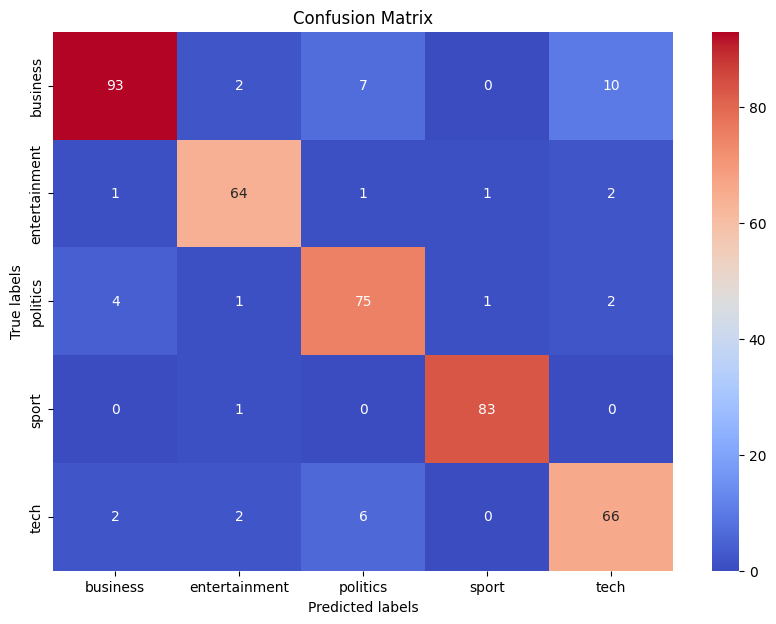

In [ ]:
calculate_accuracy(test_true, y_pred)

### **Random Forest**

**Random Forest Classifier**

In [ ]:
random_train_tfidf = train_tfidf
random_test_tfidf = test_tfidf

In [ ]:
random_classifier = RandomForestClassifier()
random_classifier.fit(random_train_tfidf, train_true)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=None,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

**Test PRediction**

Predicting Testing Performance Without HyperParameter Tuning
Accuracy: 0.9504716981132075

Precision: 0.9550254707994099

Recall: 0.9492136575067842

F1 Score: 0.9510965429522932

Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.96      0.94       112
entertainment       0.97      0.99      0.98        69
     politics       0.96      0.94      0.95        83
        sport       0.93      0.99      0.96        84
         tech       0.99      0.87      0.92        76

     accuracy                           0.95       424
    macro avg       0.96      0.95      0.95       424
 weighted avg       0.95      0.95      0.95       424


Confusion Matrix:


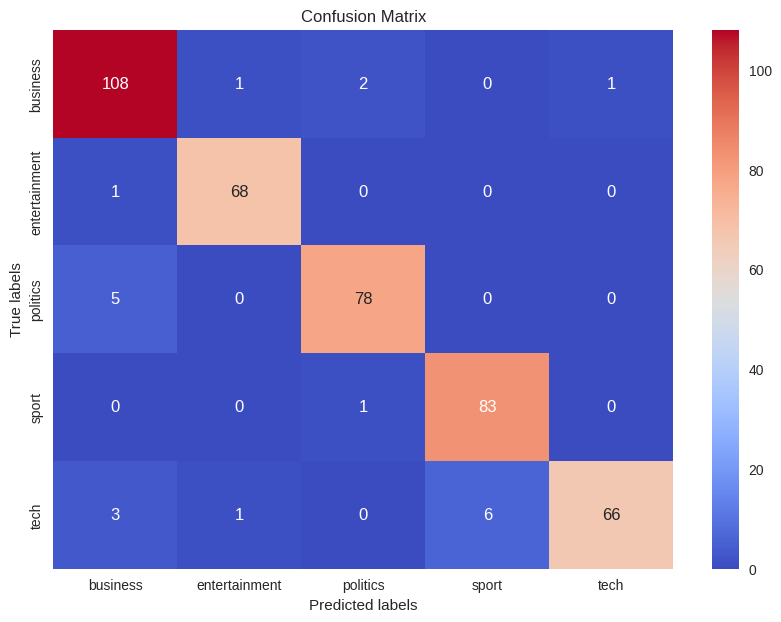

In [ ]:
random_test_pred = random_classifier.predict(random_test_tfidf)
print("Predicting Testing Performance Without HyperParameter Tuning")
calculate_accuracy(test_true, random_test_pred)

### **Logistic Regression**

**Logistic Classifier**

In [ ]:
logistic_train_tfidf = train_tfidf
logistic_test_tfidf = test_tfidf

In [ ]:
logistic_classifier = LogisticRegression()
logistic_classifier.fit(logistic_train_tfidf, train_true)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Predict Test**

Predicting Testing Performance Without HyperParameter Tuning
Accuracy: 0.964622641509434

Precision: 0.9673514162345999

Recall: 0.9645305642314271

F1 Score: 0.9654787063575483

Classification Report:
               precision    recall  f1-score   support

     business       0.95      0.96      0.96       112
entertainment       0.97      0.99      0.98        69
     politics       0.96      0.95      0.96        83
        sport       0.95      1.00      0.98        84
         tech       1.00      0.92      0.96        76

     accuracy                           0.96       424
    macro avg       0.97      0.96      0.97       424
 weighted avg       0.97      0.96      0.96       424


Confusion Matrix:


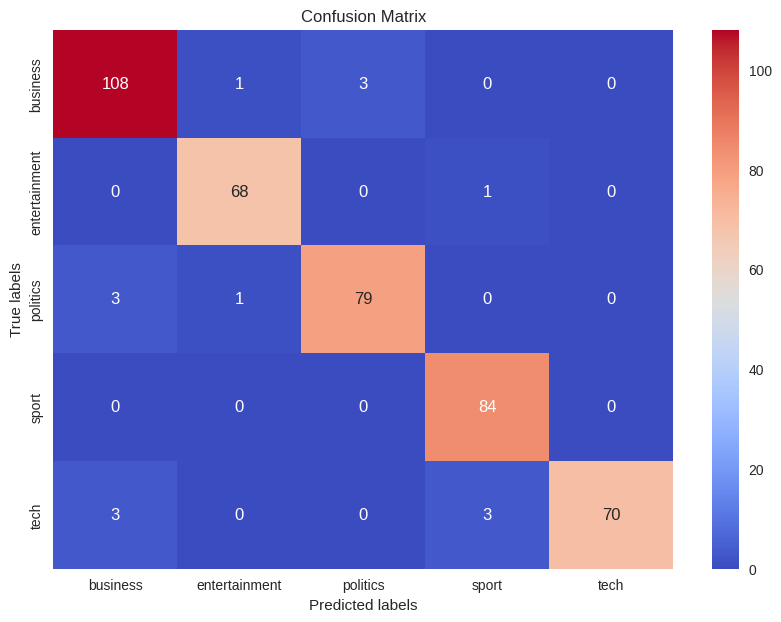

In [ ]:
logistic_test_pred = logistic_classifier.predict(logistic_test_tfidf)
print("Predicting Testing Performance Without HyperParameter Tuning")
calculate_accuracy(test_true, logistic_test_pred)

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=0c7f0011ab2cc2c21fe6fabfdcb878ee3913ac6aa71a5468f5c181b3ae89d2ae
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
y_test

1831    business
409     business
747     business
677        sport
1698       sport
          ...   
218     politics
2098    business
2091    business
351        sport
1823       sport
Name: Category, Length: 424, dtype: object

In [ ]:
X_t = X_train.reset_index().drop('index', axis=1).to_numpy()
y_t = y_train.reset_index().drop('index', axis=1).to_numpy()

In [ ]:

import lime
import lime.lime_text as lime_text
from sklearn.pipeline import make_pipeline

classifier = make_pipeline(tfidf_vectorizer, logistic_classifier)
explainer = lime_text.LimeTextExplainer(class_names=classes)

data = [[] for i in range(5)]
for sample in range(1000):
    text = X_t[sample][0]
    explanation = explainer.explain_instance(text, classifier.predict_proba, num_features=20,top_labels=5)
    class_index = np.where(classes==y_t[sample][0])[0][0]
    words = explanation.as_list(label=class_index)
    for word in words:
            data[class_index].append(word[0])




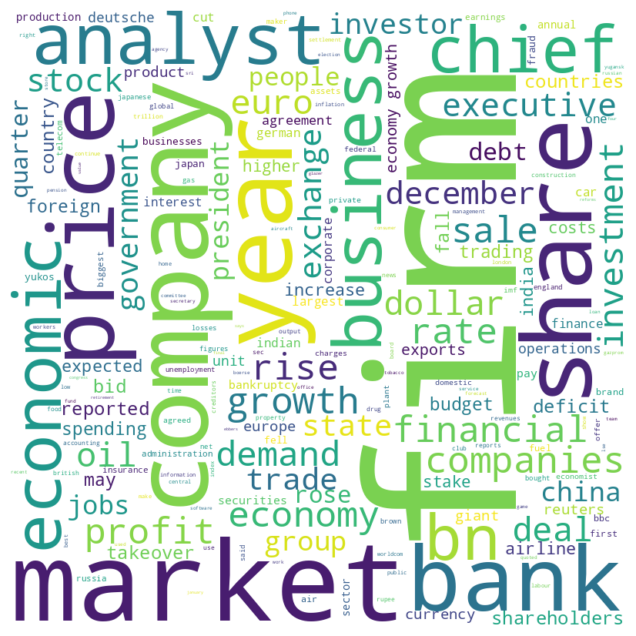

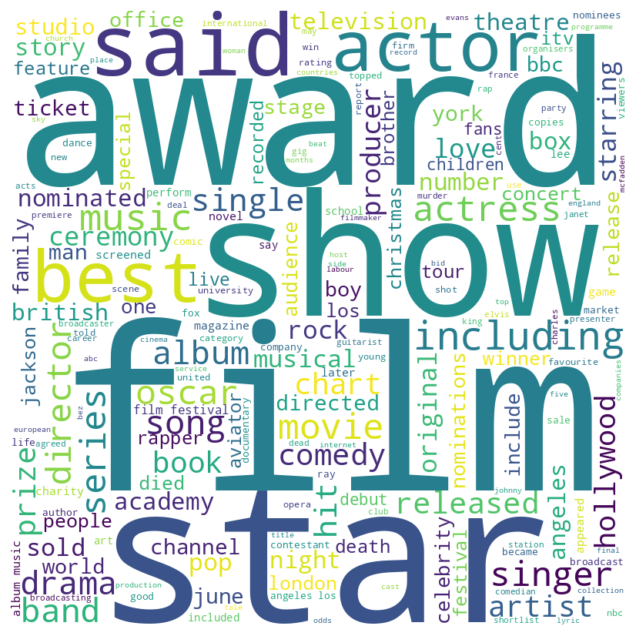

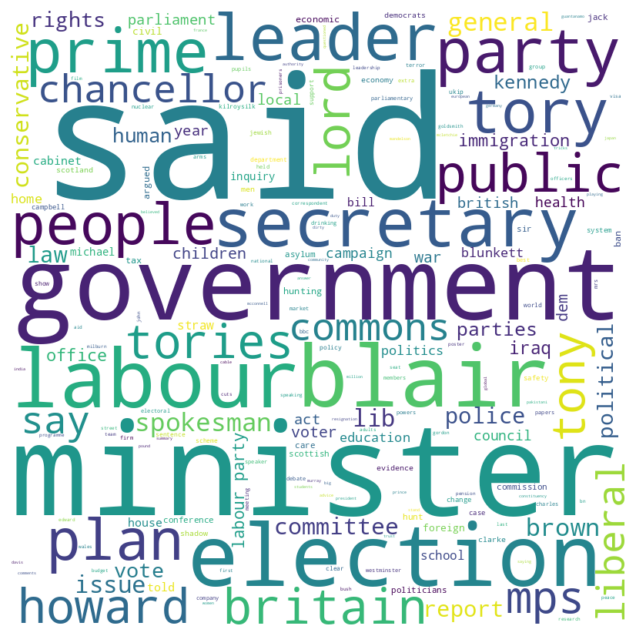

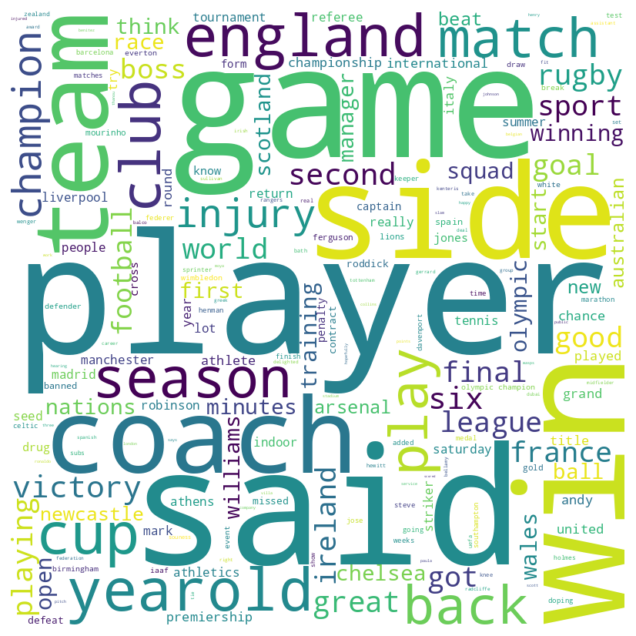

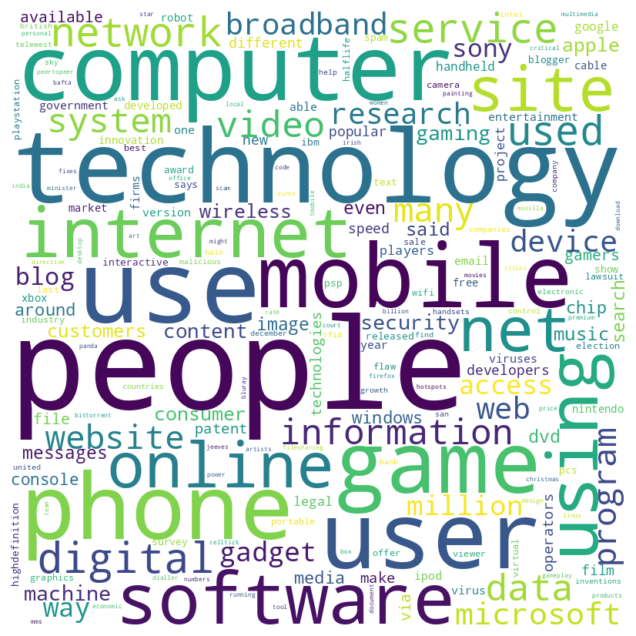

In [ ]:

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

def plot_wordcloud(data, class_index):
    words = ''
    for word in data[class_index]:
        words += word + ' '
    wordcloud = WordCloud(width=800, height=800, background_color="white", stopwords=stopwords).generate(words)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

for i in range(5):
    plot_wordcloud(data,i)


In [ ]:
classes

### **K-Nearest Neighbour (KNN)**

In [ ]:
knn_train_tfidf = train_tfidf
knn_test_tfidf = test_tfidf

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(knn_train_tfidf, train_true)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

**Test Prediction**

Predicting testing Performance Without HyperParameter Tuning
Accuracy: 0.9150943396226415

Precision: 0.9173669208058115

Recall: 0.9170857014196045

F1 Score: 0.9161597185583163

Classification Report:
               precision    recall  f1-score   support

     business       0.93      0.88      0.90       112
entertainment       0.94      0.91      0.93        69
     politics       0.84      0.93      0.88        83
        sport       0.93      0.99      0.96        84
         tech       0.94      0.88      0.91        76

     accuracy                           0.92       424
    macro avg       0.92      0.92      0.92       424
 weighted avg       0.92      0.92      0.92       424


Confusion Matrix:


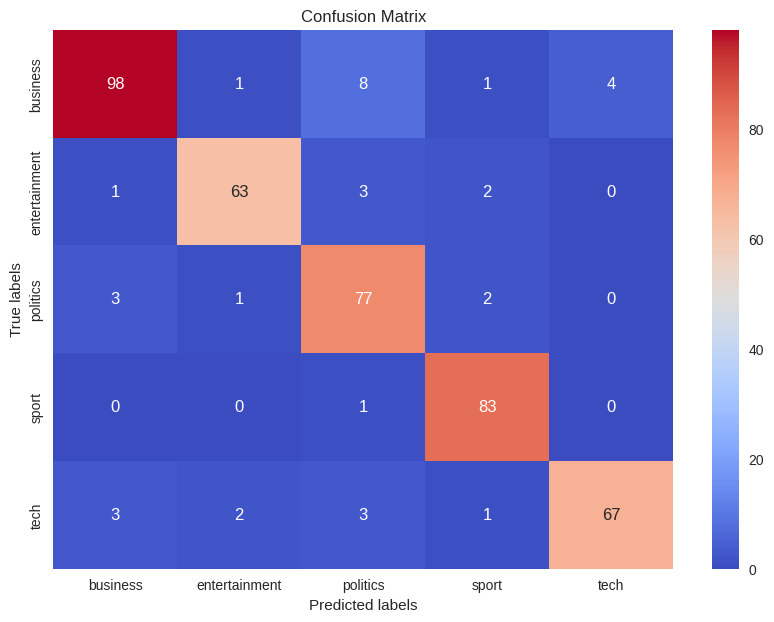

In [ ]:
knn_test_pred = knn_classifier.predict(knn_test_tfidf)
print("Predicting testing Performance Without HyperParameter Tuning")
calculate_accuracy(test_true, knn_test_pred)

### **Support Vector Machine (SVM)**

In [ ]:
svm_train_tfidf = train_tfidf
svm_test_tfidf = test_tfidf

In [ ]:
svm_classifier = SVC()
svm_classifier.fit(svm_train_tfidf, train_true)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**Test Prediction**

Predicting testing Performance Without HyperParameter Tuning
Accuracy: 0.9716981132075472

Precision: 0.975272135174243

Recall: 0.9718013768050298

F1 Score: 0.9733631442995787

Classification Report:
               precision    recall  f1-score   support

     business       0.94      0.97      0.96       112
entertainment       0.99      0.99      0.99        69
     politics       0.96      0.94      0.95        83
        sport       0.99      1.00      0.99        84
         tech       1.00      0.96      0.98        76

     accuracy                           0.97       424
    macro avg       0.98      0.97      0.97       424
 weighted avg       0.97      0.97      0.97       424


Confusion Matrix:


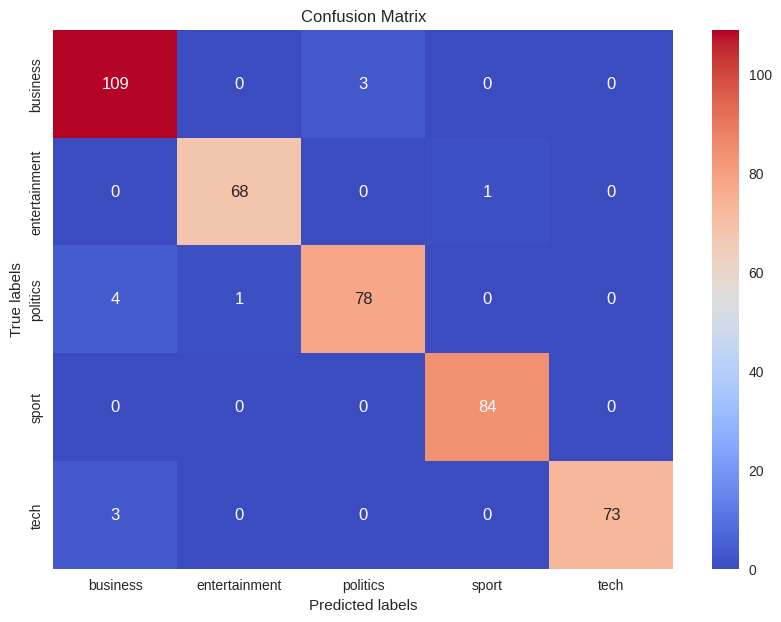

In [ ]:
svm_test_pred = svm_classifier.predict(svm_test_tfidf)
print("Predicting testing Performance Without HyperParameter Tuning")
calculate_accuracy(test_true, svm_test_pred)

### **Neural Network**

In [ ]:
nn_train_tfidf = train_tfidf
nn_test_tfidf = test_tfidf
# print(nn_train_tfidf)


In [ ]:
nn_train_tfidf.shape
# print(nn_train_tfidf.shape[1])
print(y_train_encoded)

[[0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 ...
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]]


In [ ]:
print(nn_train_tfidf.shape)
print(y_train_encoded.shape)
# y_train_encoded
# print(nn_train_tfidf)

(1695, 26814)
(1695, 5)


In [ ]:
nn_classifier = Sequential([
    Dense(16, activation='relu', input_shape=(nn_train_tfidf.shape[1],)),
    Dense(8, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

In [ ]:
nn_classifier.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = nn_classifier.fit(nn_train_tfidf, y_train_encoded, epochs=5, batch_size=16)

Epoch 1/5
106/106 [==============================] - 2s 9ms/step - loss: 1.4656 - accuracy: 0.6260
Epoch 2/5
106/106 [==============================] - 1s 11ms/step - loss: 0.7846 - accuracy: 0.9664
Epoch 3/5
106/106 [==============================] - 1s 10ms/step - loss: 0.2317 - accuracy: 0.9953
Epoch 4/5
106/106 [==============================] - 1s 10ms/step - loss: 0.0776 - accuracy: 0.9994
Epoch 5/5
106/106 [==============================] - 1s 6ms/step - loss: 0.0360 - accuracy: 1.0000


**Testing NN**

In [ ]:
predictions = nn_classifier.predict(nn_test_tfidf)

predicted_labels = np.argmax(predictions, axis=1)

print("Predicted Labels:", predicted_labels)
# accuracy = accuracy_score(np.argmax(y_test_encoded, axis=1), np.argmax(predictions, axis=1))
# print("Accuracy on test set:", accuracy)

14/14 [==============================] - 0s 2ms/step
Predicted Labels: [0 0 0 3 3 2 0 4 0 2 2 1 4 2 2 1 3 1 2 4 3 0 3 4 1 2 1 0 0 3 2 2 2 0 4 1 0
 4 3 2 2 3 1 2 3 4 0 0 3 1 1 0 1 0 2 4 0 4 1 2 3 4 4 2 1 3 0 4 4 4 2 3 4 1
 1 3 2 3 2 3 1 2 4 0 1 3 3 2 0 1 1 4 3 0 0 0 4 2 1 2 0 1 1 4 0 4 3 2 3 0 4
 2 2 4 0 2 3 0 3 4 2 3 3 3 2 0 3 2 3 4 1 0 3 1 0 3 3 2 1 4 4 3 3 1 0 2 4 3
 2 2 2 1 0 0 0 3 0 2 4 0 3 2 4 2 1 1 3 4 1 0 3 2 0 0 4 3 4 4 1 2 0 0 2 0 4
 3 0 2 0 0 0 4 1 1 4 4 0 2 4 2 0 1 2 4 2 2 4 1 4 2 3 0 1 2 0 0 3 3 3 1 1 1
 1 0 0 0 4 4 0 0 0 3 2 4 0 1 2 1 4 4 1 0 3 1 0 1 0 4 0 2 0 4 2 4 0 2 3 2 1
 0 1 0 2 3 2 2 1 0 1 4 3 0 0 0 2 3 3 1 0 0 3 0 0 2 0 0 1 3 0 2 0 0 4 2 2 2
 4 3 0 1 4 3 0 1 2 1 4 0 0 0 0 4 2 0 0 1 0 2 3 0 3 0 3 0 4 3 3 3 4 3 1 0 0
 3 2 2 3 0 0 0 2 2 1 4 0 2 3 3 0 4 3 2 1 3 0 0 4 1 4 3 3 4 0 0 2 2 4 4 3 4
 4 0 0 1 2 3 1 2 4 3 2 2 3 4 3 0 3 1 0 3 0 3 0 4 1 0 3 1 1 4 4 2 1 2 2 3 4
 1 0 3 4 0 3 3 3 0 3 0 1 2 0 0 3 3]


In [ ]:
# Map predicted labels to their corresponding classes
predicted_categories = [classes[label] for label in predicted_labels]

# Print the mapped labels
print("Mapped Predicted Labels:", predicted_categories)


Mapped Predicted Labels: ['business', 'business', 'business', 'sport', 'sport', 'politics', 'business', 'tech', 'business', 'politics', 'politics', 'entertainment', 'tech', 'politics', 'politics', 'entertainment', 'sport', 'entertainment', 'politics', 'tech', 'sport', 'business', 'sport', 'tech', 'entertainment', 'politics', 'entertainment', 'business', 'business', 'sport', 'politics', 'politics', 'politics', 'business', 'tech', 'entertainment', 'business', 'tech', 'sport', 'politics', 'politics', 'sport', 'entertainment', 'politics', 'sport', 'tech', 'business', 'business', 'sport', 'entertainment', 'entertainment', 'business', 'entertainment', 'business', 'politics', 'tech', 'business', 'tech', 'entertainment', 'politics', 'sport', 'tech', 'tech', 'politics', 'entertainment', 'sport', 'business', 'tech', 'tech', 'tech', 'politics', 'sport', 'tech', 'entertainment', 'entertainment', 'sport', 'politics', 'sport', 'politics', 'sport', 'entertainment', 'politics', 'tech', 'business', 'en

NN Test Prediction
Accuracy: 0.9787735849056604

Precision: 0.9812666273077791

Recall: 0.977917456028757

F1 Score: 0.9793941943402953

Classification Report:
               precision    recall  f1-score   support

     business       0.96      0.98      0.97       112
entertainment       1.00      0.97      0.99        69
     politics       0.98      0.98      0.98        83
        sport       0.97      1.00      0.98        84
         tech       1.00      0.96      0.98        76

     accuracy                           0.98       424
    macro avg       0.98      0.98      0.98       424
 weighted avg       0.98      0.98      0.98       424


Confusion Matrix:


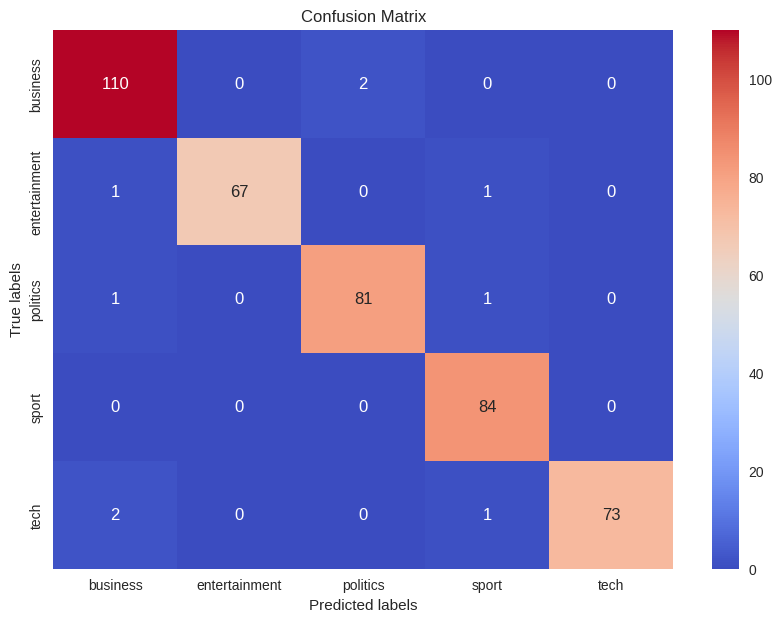

In [ ]:
print("NN Test Prediction")
calculate_accuracy(test_true, predicted_categories)

#**4 - Classification**

In [ ]:
grid_X = X
grid_y = y
grid_X_train = X_train
grid_X_test = X_test
grid_y_train = y_train
grid_y_test = y_test
grid_train_true = train_true
grid_test_true = test_true

## **Grid Search for Random Forest**

In [ ]:
def hyperparameter_tuning_random(grid_X_train, grid_y_train):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', RandomForestClassifier())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1,2],
        'classifier__n_estimators': [200,400,600,1000,1300],
        'classifier__max_depth': [10,15,20],
    }

    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(grid_X_train, grid_y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
(best_model_random, best_params_random) = hyperparameter_tuning_random(grid_X_train, grid_y_train)
best_params_random = {key: [value] for key, value in best_params_random.items()}
pd.DataFrame(best_params_random)

,classifier__max_depth,classifier__n_estimators,tfidf__max_df,tfidf__min_df,tfidf__norm
0,20,1300,0.95,2,l2


**Testing**

Predicting testing Performance With HyperParameter Tuning
Accuracy: 0.9481132075471698

Precision: 0.9523715691448176

Recall: 0.9468939996665314

F1 Score: 0.9491133782103205

Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.96      0.94       112
entertainment       0.99      0.96      0.97        69
     politics       0.94      0.94      0.94        83
        sport       0.94      0.99      0.97        84
         tech       0.97      0.89      0.93        76

     accuracy                           0.95       424
    macro avg       0.95      0.95      0.95       424
 weighted avg       0.95      0.95      0.95       424


Confusion Matrix:


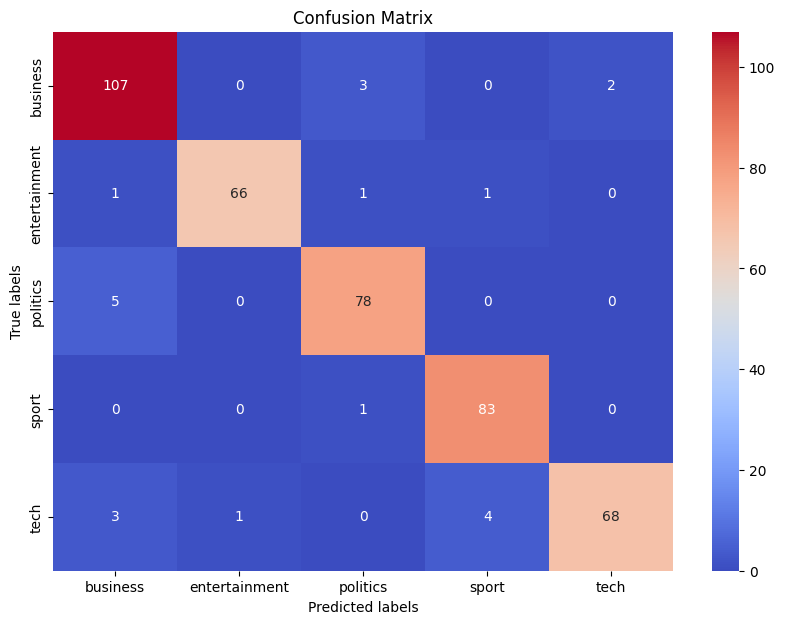

In [ ]:
grid_random_test_pred = best_model_random.predict(grid_X_test)
print("Predicting testing Performance With HyperParameter Tuning")
calculate_accuracy(grid_test_true, grid_random_test_pred)

## **Grid Search for Logistic Regression**

In [ ]:
def hyperparameter_tuning_logistic(grid_X_train, grid_y_train):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', LogisticRegression())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1, 2],
        'classifier__C': [ 0.1,1,2],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__max_iter': [100,200,300,400],
    }

    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid,cv=5, scoring=scoring)
    grid_search.fit(grid_X_train, grid_y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
(best_model_logistic, best_params_logistic) = hyperparameter_tuning_logistic(grid_X_train, grid_y_train)
best_params_logistic = {key: [value] for key, value in best_params_logistic.items()}
pd.DataFrame(best_params_logistic)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)


,classifier__C,classifier__max_iter,classifier__penalty,tfidf__max_df,tfidf__min_df,tfidf__norm
0,2,100,l2,0.95,2,l2


**Testing**

Predicting testing Performance With HyperParameter Tuning
Accuracy: 0.9716981132075472

Precision: 0.9737391839565271

Recall: 0.9713574960187268

F1 Score: 0.972231708140845

Classification Report:
               precision    recall  f1-score   support

     business       0.96      0.97      0.96       112
entertainment       0.97      0.99      0.98        69
     politics       0.98      0.96      0.97        83
        sport       0.97      1.00      0.98        84
         tech       1.00      0.93      0.97        76

     accuracy                           0.97       424
    macro avg       0.97      0.97      0.97       424
 weighted avg       0.97      0.97      0.97       424


Confusion Matrix:


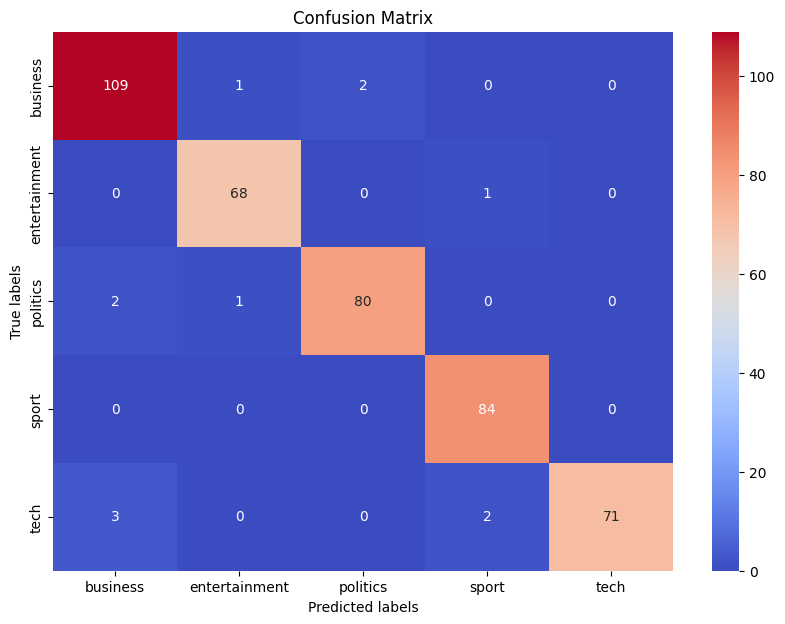

In [ ]:
grid_logistic_test_pred = best_model_logistic.predict(grid_X_test)
print("Predicting testing Performance With HyperParameter Tuning")
calculate_accuracy(grid_test_true, grid_logistic_test_pred)

## **Grid Search for KNN**

In [ ]:
def hyperparameter_tuning_knn(grid_X_train, grid_y_train):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1, 2],
        'classifier__n_neighbors': [3, 5],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'kd_tree'],
    }

    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(grid_X_train, grid_y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
(best_model_knn, best_params_knn) = hyperparameter_tuning_knn(grid_X_train, grid_y_train)
best_params_knn = {key: [value] for key, value in best_params_knn.items()}
pd.DataFrame(best_params_knn)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("canno

,classifier__algorithm,classifier__n_neighbors,classifier__weights,tfidf__max_df,tfidf__min_df,tfidf__norm
0,auto,5,uniform,0.95,2,l2


**Testing**

Predicting testing Performance With HyperParameter Tuning
Accuracy: 0.9198113207547169

Precision: 0.9224672904293458

Recall: 0.9226158310916107

F1 Score: 0.9217777881946908

Classification Report:
               precision    recall  f1-score   support

     business       0.92      0.88      0.90       112
entertainment       0.96      0.93      0.94        69
     politics       0.86      0.93      0.89        83
        sport       0.93      0.99      0.96        84
         tech       0.94      0.89      0.92        76

     accuracy                           0.92       424
    macro avg       0.92      0.92      0.92       424
 weighted avg       0.92      0.92      0.92       424


Confusion Matrix:


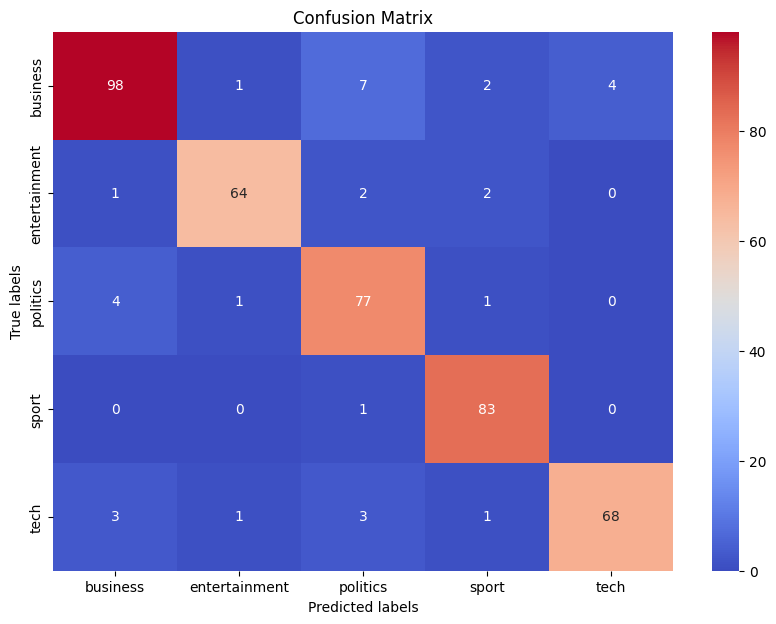

In [ ]:
grid_knn_test_pred = best_model_knn.predict(grid_X_test)
print("Predicting testing Performance With HyperParameter Tuning")
calculate_accuracy(grid_test_true, grid_knn_test_pred)

## **Grid Search for SVM**

In [ ]:
def hyperparameter_tuning_svm(grid_X_train, grid_y_train):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('classifier', SVC())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1, 2],
        'classifier__C': [ 1,2],
        'classifier__kernel': ['linear', 'sigmoid', 'poly'],
        'classifier__gamma': [0.5, 1],
        'classifier__degree': [2, 3],
    }

    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(grid_X_train, grid_y_train)

    return grid_search.best_estimator_, grid_search.best_params_

In [ ]:
(best_model_svm, best_params_svm) = hyperparameter_tuning_svm(grid_X_train, grid_y_train)
best_params_svm = {key: [value] for key, value in best_params_svm.items()}
pd.DataFrame(best_params_svm)

,classifier__C,classifier__degree,classifier__gamma,classifier__kernel,tfidf__max_df,tfidf__min_df,tfidf__norm
0,1,2,1,sigmoid,0.95,2,l2


**Testing**

Predicting testing Performance With HyperParameter Tuning
Accuracy: 0.9834905660377359

Precision: 0.983718660753255

Recall: 0.9849173746309198

F1 Score: 0.9842882185986681

Classification Report:
               precision    recall  f1-score   support

     business       0.98      0.96      0.97       112
entertainment       0.99      0.99      0.99        69
     politics       0.98      0.99      0.98        83
        sport       0.99      1.00      0.99        84
         tech       0.99      0.99      0.99        76

     accuracy                           0.98       424
    macro avg       0.98      0.98      0.98       424
 weighted avg       0.98      0.98      0.98       424


Confusion Matrix:


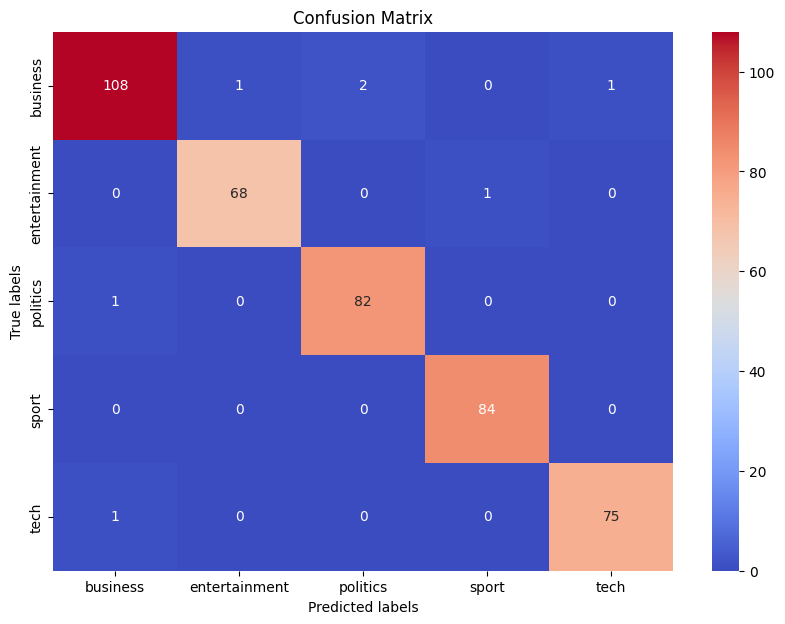

In [ ]:
grid_svm_test_pred = best_model_svm.predict(grid_X_test)
print("Predicting testing Performance With HyperParameter Tuning")
calculate_accuracy(grid_test_true, grid_svm_test_pred)

# **5 - Pycaret**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# !pip install pycaret==3.0.2

# !pip install git+https://github.com/pycaret/pycaret.git

In [ ]:
from pycaret.utils import version
version()

'3.3.2'

In [ ]:
from pycaret.classification import *

In [ ]:
data.head()

,Category,Text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [ ]:
exp_clf = setup(data = data, target = 'Category', fold=25, text_features=['Text'], train_size=0.8, text_features_method="tf-idf")

,Description,Value
0,Session id,7660
1,Target,Category
2,Target type,Multiclass
3,Target mapping,"business: 0, entertainment: 1, politics: 2, sport: 3, tech: 4"
4,Original data shape,"(2225, 2)"
5,Transformed data shape,"(2225, 27011)"
6,Transformed train set shape,"(1780, 27011)"
7,Transformed test set shape,"(445, 27011)"
8,Text features,1
9,Preprocess,True


In [ ]:
best_model = compare_models() #5 hours plus runtime

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.9815,0.0000,0.9815,0.9827,0.9813,0.9767,0.9771,6.2060
svm,SVM - Linear Kernel,0.9798,0.0000,0.9798,0.9809,0.9796,0.9746,0.9750,7.2544
lr,Logistic Regression,0.9730,0.0000,0.9730,0.9748,0.9729,0.9661,0.9666,10.7888
lightgbm,Light Gradient Boosting Machine,0.9646,0.9976,0.9646,0.9660,0.9644,0.9555,0.9560,103.9516
et,Extra Trees Classifier,0.9584,0.9974,0.9584,0.9622,0.9582,0.9476,0.9487,8.8836
gbc,Gradient Boosting Classifier,0.9578,0.0000,0.9578,0.9606,0.9578,0.9471,0.9478,290.4256
xgboost,Extreme Gradient Boosting,0.9572,0.9967,0.9572,0.9599,0.9571,0.9464,0.9471,184.9452
rf,Random Forest Classifier,0.9494,0.9964,0.9494,0.9524,0.9491,0.9364,0.9373,6.0672
nb,Naive Bayes,0.9202,0.9503,0.9202,0.9264,0.9202,0.8999,0.9014,4.0820
knn,K Neighbors Classifier,0.9191,0.9878,0.9191,0.9309,0.9196,0.8986,0.9014,4.1312


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('  ').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

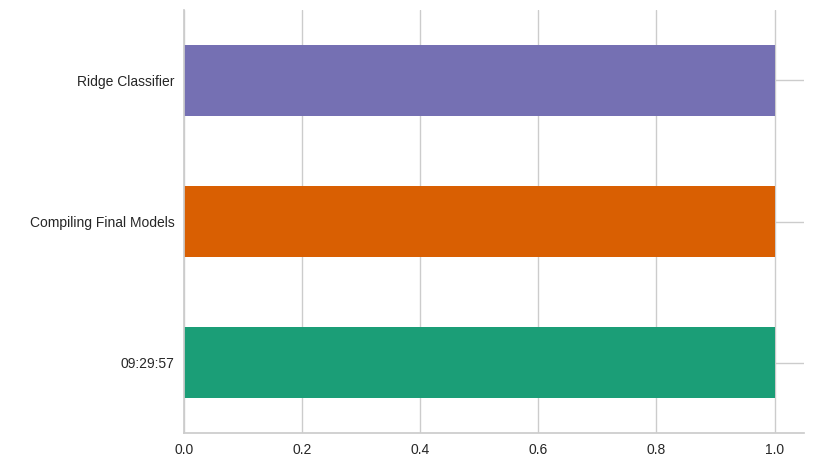

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('  ').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
model = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9861,0.0000,0.9861,0.9869,0.9860,0.9826,0.9828
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9444,0.0000,0.9444,0.9481,0.9444,0.9303,0.9312
4,0.9861,0.0000,0.9861,0.9871,0.9861,0.9826,0.9828
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9859,0.0000,0.9859,0.9867,0.9859,0.9823,0.9826
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9861,0.0000,0.9861,0.9869,0.9860,0.9826,0.9828
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9444,0.0000,0.9444,0.9481,0.9444,0.9303,0.9312
4,0.9861,0.0000,0.9861,0.9871,0.9861,0.9826,0.9828
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9859,0.0000,0.9859,0.9867,0.9859,0.9823,0.9826
7,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 25 folds for each of 10 candidates, totalling 250 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
final_model = finalize_model(tuned_model)

In [ ]:
predictions = predict_model(final_model, data = data) #final

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.9996,0,0.9996,0.9996,0.9996,0.9994,0.9994


In [ ]:
print(predictions.head())

                                                Text       Category  \
0  tv future in the hands of viewers with home th...           tech   
1  worldcom boss  left books alone  former worldc...       business   
2  tigers wary of farrell  gamble  leicester say ...          sport   
3  yeading face newcastle in fa cup premiership s...          sport   
4  ocean s twelve raids box office ocean s twelve...  entertainment   

  prediction_label  
0             tech  
1         business  
2            sport  
3            sport  
4    entertainment  


# **6 - Conclusion**

In [ ]:
test_scores = {
    'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'SVM', 'NN'],
    # 'Train Accuracy in % (Without Hyperparemeter Tuning)':[100.00, 99.71, 94.90, 100, 99.91],
    'Test Accuracy in % (Without Hyperparemeter Tuning)': [95.52, 98.32, 93.89, 98.30, 98.24],
    # 'Train Accuracy in % (With Hyperparemeter Tuning)':[100.00, 99.96, 95.26, 99.82, "NA"],
    'Test Accuracy in % (With Hyperparemeter Tuning)': [96.49, 97.92, 93.48, 98.24, "NA"]
}

pd.DataFrame(test_scores)

,Model,Test Accuracy in % (Without Hyperparemeter Tuning),Test Accuracy in % (With Hyperparemeter Tuning)
0,Random Forest,95.52,96.49
1,Logistic Regression,98.32,97.92
2,KNN,93.89,93.48
3,SVM,98.30,98.24
4,NN,98.24,NA
